In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/300/'

os.chdir(current_path)

Mounted at /content/drive


### **Requirements**

In [ ]:
# !pip install statsmodels==0.12.2

# import statsmodels
# statsmodels.__version__

### **ARIMA**

In [2]:
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.arima.model import ARIMA

from datetime import datetime


def arima_test(target, use_rows=None):

  size = int(len(target) * 0.66)
  train, test = target[:size].values, target[size:]
  test_shift = test.shift(1).values
  test = test.values
  # break

  history = list(train)
  predictions = list()
  err_ranges = list()
  for t in range(len(test)):
    
      if use_rows is not None:
        history = history[-use_rows:]
        
      model = ARIMA(history, order=(0, 2, 4))
      model_fit = model.fit()
      output = model_fit.forecast()
      # print(output)
      # break

      predictions.append(output[0])
      err_ranges.append(output[1])
      obs = test[t]
      # print('obs :', obs)
      history.append(obs)
      # break
      print('\r %.2f%%' % (t / len(test) * 100), end='')

  print(len(test), len(predictions))

  return predictions, err_ranges


# print(high)


def get_back_result(ohlcv, predictions, err_ranges, tp=0.04, sl=None, leverage=1, show_detail=False, show_plot=False, return_pr=False, cumsum=False, 
                    close_ver=False, reverse_short=False):

  
  high, low, test = np.split(ohlcv.values[-len(predictions):, [1, 2, 3]], 3, axis=1)

  if close_ver:
    predictions = ohlcv['close'].shift(1).values[-len(test):]

  fee = 0.0006
  long_profits = []
  short_profits = []
  liquidations = []
  win_cnt = 0
  for i in range(len(test)):

    long_ep = predictions[i]
    if sl is not None:
      long_sl = long_ep * (1 / (sl + 1))

    # assert long_ep < long_exit, 'long_exit < long_ep !, %s, %s' % (long_exit, long_ep)
    
    short_ep = (predictions[i] + err_ranges[i]) * (1 + tp)
    # short_ep = (predictions[i] + err_ranges[i]) * (1 / (1 - tp))
    if sl is not None:
      short_sl = short_ep * (1 / (1 - sl))

    # print((low[i]))

    #    long 우선   # <-- long & short 둘다 체결된 상황에서는 long 체결을 우선으로 한다.
    if low[i] < long_ep:
      
      liquidation = low[i] / long_ep - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      liquidations.append(l_liquidation)

      if max(l_liquidation, 0) == 0:
        l_profit = 0
        # print('low[i], long_ep, l_liquidation :', low[i], long_ep, l_liquidation)
      else:

        if sl is not None:
          if low[i] < long_sl:
            profit = long_sl / long_ep - fee
          else:
            profit = test[i] / long_ep - fee

        else:
          profit = test[i] / long_ep - fee

        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)
        
        if profit >= 1:
          win_cnt += 1

      long_profits.append(l_profit)
      short_profits.append(1.0)

      if show_detail:
        print(test[i], predictions[i], long_ep)

    # if high[i] > short_ep > low[i]: # 지정 대기가 아니라, 해당 price 가 지나면, long 한다.

    #   if not reverse_short:
    #     liquidation = short_ep / high[i]  - fee
    #   else:
    #     liquidation = low[i] / short_ep  - fee
    #   l_liquidation = 1 + (liquidation - 1) * leverage

    #   if max(l_liquidation, 0) == 0:
    #     l_profit = 0
    #   else:

    #     if sl is not None:
    #       if high[i] > short_sl:

    #         if not reverse_short:
    #           profit = short_ep / short_sl - fee
    #         else:
    #           profit = short_sl / short_ep - fee

    #       else:
    #         if not reverse_short:
    #           profit = short_ep / test[i] - fee
    #         else:
    #           profit = test[i] / short_ep - fee

    #     else:

    #       if not reverse_short:
    #         profit = short_ep / test[i] - fee
    #       else:
    #         profit = test[i] / short_ep - fee

    #     l_profit = 1 + (profit - 1) * leverage
    #     l_profit = max(l_profit, 0)

    #     if profit >= 1:
    #       win_cnt += 1

    #   short_profits.append(l_profit)
    #   long_profits.append(1.0)

    #   if show_detail:
    #     print(test[i], predictions[i], short_ep)
    
    else:
      long_profits.append(1.0)
      short_profits.append(1.0)
      liquidations.append(1.0)


  long_win_ratio = sum(np.array(long_profits) > 1.0) / sum(np.array(long_profits) != 1.0)
  short_win_ratio = sum(np.array(short_profits) > 1.0) / sum(np.array(short_profits) != 1.0)
  long_frequency = sum(np.array(long_profits) != 1.0) / len(test)
  short_frequency = sum(np.array(short_profits) != 1.0) / len(test)
  if not cumsum:
    long_accum_profit = np.array(long_profits).cumprod()
    short_accum_profit = np.array(short_profits).cumprod()
  else:
    long_accum_profit = (np.array(long_profits) - 1.0).cumsum()
    short_accum_profit = (np.array(short_profits) - 1.0).cumsum()

  # print(win_ratio)

  if show_plot:

    plt.figure(figsize=(10, 5))
    plt.suptitle('tp=%.4f, lvrg=%d' % (tp, leverage))

    plt.subplot(151)
    plt.plot(liquidations)
    plt.title('liquidations')

    plt.subplot(152)
    plt.plot(long_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (long_win_ratio * 100, long_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(153)
    plt.plot(long_accum_profit)
    plt.title('Accum_profit : %.2f' % long_accum_profit[-1], color='black')

    plt.subplot(154)
    plt.plot(short_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (short_win_ratio * 100, short_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(155)
    plt.plot(short_accum_profit)
    plt.title('Accum_profit : %.2f' % short_accum_profit[-1], color='black')
    plt.show()

  return [long_win_ratio, short_win_ratio], [long_frequency, short_frequency], [long_accum_profit[-1], short_accum_profit[-1]], [long_profits, short_profits]


# get_back_result(tp=0.04, leverage=1, show_plot=True)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

interval = '30m'
date_path = './candlestick_concated/%s/2021-04-27/' % interval
file_list = os.listdir(date_path)

print((file_list))

['2021-04-27 BTCUSDT.xlsx', '2021-04-27 ETHUSDT.xlsx', '2021-04-27 BCHUSDT.xlsx', '2021-04-27 XRPUSDT.xlsx', '2021-04-27 EOSUSDT.xlsx', '2021-04-27 LTCUSDT.xlsx', '2021-04-27 ETCUSDT.xlsx', '2021-04-27 LINKUSDT.xlsx', '2021-04-27 XLMUSDT.xlsx', '2021-04-27 ADAUSDT.xlsx', '2021-04-27 XMRUSDT.xlsx', '2021-04-27 SXPUSDT.xlsx', '2021-04-27 KAVAUSDT.xlsx', '2021-04-27 BANDUSDT.xlsx', '2021-04-27 DASHUSDT.xlsx', '2021-04-27 ZECUSDT.xlsx', '2021-04-27 XTZUSDT.xlsx', '2021-04-27 BNBUSDT.xlsx', '2021-04-27 ATOMUSDT.xlsx', '2021-04-27 ONTUSDT.xlsx', '2021-04-27 IOTAUSDT.xlsx', '2021-04-27 BATUSDT.xlsx', '2021-04-27 NEOUSDT.xlsx', '2021-04-27 QTUMUSDT.xlsx', '2021-04-27 WAVESUSDT.xlsx', '2021-04-27 MKRUSDT.xlsx', '2021-04-27 SNXUSDT.xlsx', '2021-04-27 DOTUSDT.xlsx', '2021-04-27 THETAUSDT.xlsx', '2021-04-27 ALGOUSDT.xlsx', '2021-04-27 KNCUSDT.xlsx', '2021-04-27 ZRXUSDT.xlsx', '2021-04-27 COMPUSDT.xlsx', '2021-04-27 OMGUSDT.xlsx']


### **Model**

In [4]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

%tensorflow_version 1.x

import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display

%matplotlib inline

from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


gdrive_path = current_path

num_classes = 2

def FER_Model(input_shape):
    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    # net = layers.LSTM(32, return_sequences=False)(visible)
    net = layers.LSTM(10, return_sequences=False)(visible)

    # net = layers.Dense(32)(visible)
    # net = layers.Conv2D(32, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = layers.BatchNormalization()(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(64)(net)
    # net = layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.BatchNormalization()(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.BatchNormalization()(net)

    # net = layers.MaxPool2D(pool_size=2)(net)
    # net = layers.AveragePooling2D(padding='same')(net)

    shortcut_1 = net

    net = layers.Dense(128)(net)
    # net = layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(256)(net)
    # net = layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.BatchNormalization()(net)


    # net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_2 = net

#     net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

#     shortcut_3 = net

#     net = layers.Conv2D(128, kernel_size=1, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

    # net = layers.Flatten()(net)
    net = layers.Dense(128)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(64)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dropout(0.3)(net)

    net = layers.Dense(num_classes, activation='softmax')(net)

    # create model 
    model = Model(inputs=visible, outputs=net)
    # summary layers
    print(model.summary())
    
    return model

TensorFlow 1.x selected.


Using TensorFlow backend.


### **Data Stacking**

In [5]:
def resize_npy(x):

  temp_x = []

  for d_i, data in enumerate(x):
    # resized_data = cv2.resize(data, (row * 2, col * 2)) --> input image 홰손된다
    # resized_data = data.repeat(2, axis=0).repeat(2, axis=1)
    data = data.repeat(2, axis=0).repeat(2, axis=1)
    # resized_data = data.repeat(1, axis=0).repeat(1, axis=1)
    # cmapped = plt.cm.Set1(resized_data)[:, :, :3]  # Drop Alpha Channel
    
    if d_i == 0:
      plt.imshow(data)
      plt.show()
      # plt.imshow(resized_data)
      # plt.show()
    # print('resized_data.shape :', resized_data.shape)
    # break
    temp_x.append(data)

  return temp_x

In [6]:
def min_max_scale(npy_x):

  return (npy_x - np.min(npy_x)) / (np.max(npy_x) - np.min(npy_x))


def class_ratio(in_list):

  return in_list / in_list[1]

In [ ]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import pickle
from sklearn.model_selection import train_test_split
from datetime import datetime

from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import class_weight

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from funcs_indicator import *
from tqdm.notebook import tqdm


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

np.random.shuffle(file_list)
candis = file_list

long_index = 0
leverage = 5
prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)


for i in range(len(candis)):

  keys = [candis[i]]
  
  # if 'algo'.upper() not in candis[i]:
  #   continue


  # if '02-11' not in candis[i]:  # <-- 04-08 includes all timestamp range
  #   continue  

  # if 'eth'.upper() not in candis[i]:
  #   continue

  # if 'neo'.upper() not in candis[i]:
  #   continue

  # plt.figure(figsize=(35, 10))
  # plt.suptitle('%s %s' % (interval, keys))


  #         get tp parameter        #

  # plt.subplot(1,10,3)
  # for key in keys:  
  #   # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['ap_list'])
  #   argmax = np.argmax(profit_result_dict[key]['ap_list'][:, [long_index]])
  #   peak_tp = profit_result_dict[key]['tp_list'][argmax]
  #   # plt.axvline(peak_tp, linestyle='--')
  #   # plt.title('acc profit, max at %.4f' % (peak_tp))  

  # plt.subplot(1,10,4)
  # plt.title('max acc profit by leverage')  
  # for key in keys:  
  #   # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['max_ap_list'], label=key)
  #   argmax = np.argmax(profit_result_dict[key]['max_ap_list'][:, [long_index]])
  #   max_peak_tp = profit_result_dict[key]['tp_list'][argmax]
  #   # plt.axvline(max_peak_tp, linestyle='--')
  #   # plt.title('max acc profit, max at %.4f' % (max_peak_tp))  


  for key in keys:  

    # print(profit_result_dict[key]['leverage_ap_list'])

    # for tp in [max_peak_tp]:

      # if tp == peak_tp:
      #   plt.subplot(1,10,5)
      # else:
      #   plt.subplot(1,10,6)

      #     leverage analysis     #
      # ohlcv = load_dict[key]['ohlcv']

    if 'sxp'.upper() not in key:
      continue
    
    ohlcv = pd.read_excel(date_path + key, index_col=0)
    print('len(ohlcv) :', len(ohlcv))


    #       select timestamp range      #
    # time_index = ohlcv.index
    # total_stamp = list(map(lambda x: datetime.timestamp(x), time_index)) 

    # rm_index_amt = np.sum(np.array(total_stamp) < start_stamp)

    # ohlcv = ohlcv.iloc[rm_index_amt:]
    # print(ohlcv.head())

    # ohlcv = ohlcv.iloc[:-2603]  # exclude back_range
    # ohlcv = ohlcv.iloc[:-int(len(ohlcv) * 0.3)]  # exclude back_range
    # predictions = load_dict[key]['predictions']
    # err_ranges = load_dict[key]['err_ranges']
    print("ohlcv.index[0] :", ohlcv.index[0])
    print("ohlcv.index[-1] :", ohlcv.index[-1])

    predictions = ohlcv['close'].shift(1).values
    err_ranges = np.zeros_like(predictions)

    # leverage_list = profit_result_dict[key]['leverage_list']
    # temp_ap_list = list()
    # temp_pr_list = list()

    try:
      print('-------------- %s --------------' % key)
      result = get_back_result(ohlcv, predictions, err_ranges, tp=0, leverage=leverage, show_plot=True, reverse_short=False, show_detail=False)
      # temp_ap_list.append(result[2])
      # temp_pr_list.append(result[3])

      # if round(leverage) == 1:
      #   temp_pr_list = result[3]
      pr_list = result[3][long_index]

    except Exception as e:
      print(e)
      break    


    
  # break
    #         clustering zone           #

    #       set data features : ohlc, v, ep
    time_index = ohlcv.index[-len(predictions):]

    sliced_ohlcv = ohlcv[-len(predictions):]

    #       scale with price    #
    ohlc = ohlcv.iloc[-len(predictions):, :4]      
    long_ep = np.array(predictions)
    long_ep = long_ep.reshape(-1, 1)
    ha_ohlc = heikinashi(sliced_ohlcv).iloc[:, :4]
    sar = lucid_sar(sliced_ohlcv)
    ema1, ema2, ema3 = ema_ribbon(sliced_ohlcv)
    senkou1, senkou2 = ichimoku(sliced_ohlcv)

    #     min max scale   #
    vol = sliced_ohlcv.iloc[-len(predictions):, [4]]

    #     scale with baseline   #
    #     방법 1. 전체 기간 min_max scaling   #
    # cbo, ema_cbo = cct_bbo(sliced_ohlcv, 21, 13) 

    # _, _, bbw = bb_width(sliced_ohlcv, 20, 2) 
    
    # fish = fisher(sliced_ohlcv, 60)
    # trix = trix_hist(sliced_ohlcv, 14, 1, 5) 
    # rsi_ = rsi(sliced_ohlcv)
    # macd_hist = macd(sliced_ohlcv)




    # ohlcv['u_wick'] = ohlcv['high'] / np.maximum(ohlcv['close'] , ohlcv['open'])
    # ohlcv['d_wick'] = np.minimum(ohlcv['close'] , ohlcv['open']) / ohlcv['low']
    # ohlcv['body'] = ohlcv['close'] / ohlcv['open']
    # candle = ohlcv.iloc[-len(predictions):, -3:]


    print('len(ohlc) :', len(ohlc))
    print('long_ep.shape :', long_ep.shape)
    print('len(ha_ohlc) :', len(ha_ohlc))
    print('len(sar) :', len(sar))
    print('len(ema1) :', len(ema1))
    print('len(senkou1) :', len(senkou1))
    # print('len(cbo) :', len(cbo))
    # print('len(ema_cbo) :', len(ema_cbo))
    # print('len(bbw) :', len(bbw))
    # print('len(fish) :', len(fish))
    # print('len(trix) :', len(trix))
    # print('len(rsi_) :', len(rsi_))
    # print('len(macd_hist) :', len(macd_hist))


    # break


    #       set params    #
    period = 45
    # key_i = i

    # # plt.plot(cbo)
    # # plt.plot(bbw)
    # plt.plot(fish, color='b')
    # # plt.plot(trix)
    # # plt.plot(rsi_)
    # # plt.plot(macd_hist)
    # plt.show()

    #      global scaling   #
    # min_max = MinMaxScaler()
    # cbo = min_max.fit_transform(cbo.values.reshape(-1, 1))
    # ema_cbo = min_max.fit_transform(ema_cbo.values.reshape(-1, 1))
    # bbw = min_max.fit_transform(bbw.values.reshape(-1, 1))
    # fish = min_max.fit_transform(fish.values.reshape(-1, 1))
    # trix = min_max.fit_transform(trix.values.reshape(-1, 1))
    # rsi_ = min_max.fit_transform(rsi_.values.reshape(-1, 1))
    # macd_hist = min_max.fit_transform(macd_hist.values.reshape(-1, 1))

    # # plt.plot(cbo)
    # # plt.plot(bbw)
    # plt.plot(fish, color='r')
    # # plt.plot(trix)
    # # plt.plot(rsi_)
    # # plt.plot(macd_hist)
    # plt.show()
    # break

    plotting = True

    for trial_number in range(1):

      data_x, data_pr, data_updown = [], [], []
      data_index = []

      for i in range(period, len(predictions)):

        #   pr_list != 1 인 데이터만 사용한다
        # if 1:
        if pr_list[i] != 1:

          min_max = MinMaxScaler()
          
          #   prediction 을 제외한 이전 데이터를 사용해야한다
          temp_ohlc = ohlc.iloc[i - period : i].values
          temp_long_ep = long_ep[i - period : i]          
          temp_ha_ohlc = ha_ohlc.iloc[i - period : i].values
          temp_sar = sar.iloc[i - period : i].values.reshape(-1, 1)
          temp_ema1 = ema1.iloc[i - period : i].values.reshape(-1, 1)
          temp_ema2 = ema2.iloc[i - period : i].values.reshape(-1, 1)
          temp_ema3 = ema3.iloc[i - period : i].values.reshape(-1, 1)
          temp_senkou1 = senkou1.iloc[i - period : i].values.reshape(-1, 1)
          temp_senkou2 = senkou2.iloc[i - period : i].values.reshape(-1, 1)          

          price_data = np.hstack((temp_ohlc, temp_long_ep, temp_ha_ohlc, temp_sar, temp_ema1, temp_ema2, temp_ema3, temp_senkou1, temp_senkou2))

          if np.isnan(np.sum(price_data)):
            continue

          # print("price_data[:10] :", price_data[:10])
          # print("temp_ohlc.shape :", temp_ohlc.shape)
          # print("temp_long_ep.shape :", temp_long_ep.shape)
          # print("temp_ha_ohlc.shape :", temp_ha_ohlc.shape)
          # print("price_data.shape :", price_data.shape)

          if plotting:
            plt.plot(price_data)
            plt.show()

          temp_price_data = min_max_scale(price_data)
          # temp_price_data = (price_data - np.min(price_data)) / (np.max(price_data) - np.min(price_data))

          temp_ohlc = temp_price_data[:, :4]
          temp_long_ep = temp_price_data[:, [4]]
          temp_ha_ohlc = temp_price_data[:, 5:9]
          temp_sar, temp_ema1, temp_ema2, temp_ema3, temp_senkou1, temp_senkou2 = np.split(temp_price_data[:, 9:], 6, axis=1)

          if plotting:

            plt.plot(temp_price_data)
            plt.show()

            plotting = False
          # break

          #   vol -> min_max
          temp_vol = min_max.fit_transform(vol.iloc[i - period : i].values.reshape(-1, 1))
          
          # temp_candle = candle.iloc[i - period : i].values

          # temp_cbo = cbo[i - period : i]
          # temp_ema_cbo = ema_cbo[i - period : i]
          # temp_bbw = bbw[i - period : i]
          # temp_fish = fish[i - period : i]
          # temp_trix = trix[i - period : i]
          # temp_rsi_ = rsi_[i - period : i]
          # temp_macd_hist = macd_hist[i - period : i]

          # # print(temp_ohlc.shape)
          # # print(temp_long_ep.shape)
          # # print(temp_vol.shape)
          # # print(temp_candle.shape)
          # # break

          # trial_list = [temp_ha_ohlc, temp_sar, temp_ema1, temp_ema2, temp_ema3, temp_senkou1, temp_senkou2,
          #               temp_cbo, temp_ema_cbo, temp_bbw, temp_fish, temp_trix, temp_rsi_, temp_macd_hist]

          # trial_list = [temp_ohlc[:, [0], temp_ohlc[:, [1], temp_ohlc[:, [2], temp_ohlc[:, [3]], temp_vol, temp_ema_cbo]

          #                   feature selection                   #  
          # temp_data = np.hstack((temp_ohlc, temp_long_ep, temp_vol, temp_candle))
          # temp_data = trial_list[trial_number]
          # temp_data = np.hstack((temp_ohlc[:, [3]], temp_ohlc[:, [1]], temp_bbw))
          temp_data = temp_ohlc[:, [3]]
          # temp_data = np.hstack((temp_ohlc, temp_vol))

          #     only close    #
          # temp_data = temp_ohlc[:, [-1]]

          # temp_data = temp_ohlc

          #     only volume    #
          # temp_data = temp_vol

          # temp_data = np.hstack((temp_ohlc, temp_long_ep))
          # temp_data = temp_vol

          #   scaler 설정

          #   ohlc & ep -> max_abs
          # max_abs = MaxAbsScaler()
          # temp_data[:, :-1] = max_abs.fit_transform(temp_data[:, :-1])

          
          # min_max = MinMaxScaler()
          # temp_data = min_max.fit_transform(temp_data)

          #   candle -> max_abs    
          # max_abs = MaxAbsScaler()
          # temp_data[:, -3:] = max_abs.fit_transform(temp_data[:, -3:])

          # min_max = MinMaxScaler()
          # temp_data[:, -3:] = min_max.fit_transform(temp_data[:, -3:])

          if np.isnan(np.sum(temp_data)):
            continue

          data_x.append(temp_data)
          data_pr.append(pr_list[i])
          data_index.append(time_index[i])
          data_updown.append(ohlc['close'].iloc[i] / ohlc['open'].iloc[i])


      print('np.array(data_x).shape :', np.array(data_x).shape)
      # print(data_x[0])


      #       Reshape data for image deep - learning     #
      _, row, col = np.array(data_x).shape

      # input_x = np.array(data_x).reshape(-1, row, col, 1).astype(np.float32)
      input_x = np.array(data_x).reshape(-1, row, col).astype(np.float32)

      #     1c to 3c    #
      # input_x = input_x * np.ones(3, dtype=np.float32)[None, None, None, :]
      # input_x = np.array(resize_npy(input_x))


      input_pr = np.array(data_pr).reshape(-1, 1).astype(np.float32)
      input_ud = np.array(data_updown).reshape(-1, 1).astype(np.float32)
      input_index = np.array(data_index).reshape(-1, 1)
      print('input_x.shape :', input_x.shape)
      print('input_x.dtype :', input_x.dtype)
      print('input_pr.shape :', input_pr.shape)
      print('input_ud.shape :', input_ud.shape)
      print('input_index.shape :', input_index.shape)


      # x_train_, x_test, pr_train_, pr_test, ud_train_, ud_test = train_test_split(input_x, input_pr, input_ud, test_size=0.4, shuffle=False, random_state=random_state)
      # x_train, x_val, pr_train, pr_val, ud_train, ud_val = train_test_split(x_train_, pr_train_, ud_train_, test_size=0.25, shuffle=False, random_state=random_state)

      #     do stacking   #
      # if prev_x is None:
      prev_x = input_x
      prev_pr = input_pr
      prev_ud = input_ud
      prev_index = input_index

      total_x = input_x
      total_pr = input_pr
      total_ud = input_ud
      total_index = input_index

      # else:
      #   total_x = np.vstack((prev_x, input_x))
      #   total_pr = np.vstack((prev_pr, input_pr))
      #   total_ud = np.vstack((prev_ud, input_ud)) 
      #   total_index = np.vstack((prev_index, input_index)) 

      #   prev_x = total_x
      #   prev_pr = total_pr
      #   prev_ud = total_ud
      #   prev_index = total_index

      print('total_x.shape :', total_x.shape)
      print('total_pr.shape :', total_pr.shape)
      print('total_ud.shape :', total_ud.shape)
      print('prev_index.shape :', prev_index.shape)

      
      # _, row, col, _ = input_x.shape
      _, row, col = input_x.shape

      #       split new test      #

      seed = 1
      random_state = 202
      np.random.seed(seed)
      from sklearn.model_selection import train_test_split
  
      symbol_name = key.split(' ')[1].split('.')[0]

      print(np.unique(total_index, return_counts=True))
      uniq_stamp = np.unique(total_index)

      stamp_train_, stamp_test = train_test_split(uniq_stamp, test_size=0.2, shuffle=False, random_state=random_state)
      stamp_train, stamp_val = train_test_split(stamp_train_, test_size=0.25, shuffle=True, random_state=random_state)

      print("stamp_train.shape :", stamp_train.shape)
      print("stamp_val.shape :", stamp_val.shape)
      print("stamp_test.shape :", stamp_test.shape)
      # break


      #         split data by stamp     #
      x_train, x_val, x_test = [], [], []
      pr_train, pr_val, pr_test = [], [], []
      index_train, index_val, index_test = [], [], []


      from tqdm.notebook import tqdm

      np.random.shuffle(total_index)

      for i in tqdm(range(len(total_index))):

        if total_index[i] in stamp_train:
          x_train.append(total_x[i])
          pr_train.append(total_pr[i])
          index_train.append(total_index[i])

        elif total_index[i] in stamp_val:
          x_val.append(total_x[i])
          pr_val.append(total_pr[i])
          index_val.append(total_index[i])
        
        elif total_index[i] in stamp_test:
          x_test.append(total_x[i])
          pr_test.append(total_pr[i])
          index_test.append(total_index[i])


      x_train = np.array(x_train)
      x_val = np.array(x_val)
      x_test = np.array(x_test)

      pr_train = np.array(pr_train)
      pr_val = np.array(pr_val)
      pr_test = np.array(pr_test)

      y_test = np.where(pr_test > 1, 1, 0)


      index_train = np.array(index_train)
      index_val = np.array(index_val)
      index_test = np.array(index_test)
        
      print("x_train.shape :", x_train.shape) # x_train.shape : (3807, 90, 12, 3)
      print("x_val.shape :", x_val.shape) # x_train.shape : (3807, 90, 12, 3)
      print("x_test.shape :", x_test.shape) # x_train.shape : (3807, 90, 12, 3)

      #     test 로 부터 index 한개씩, train / val 로 붙이고 train / val 로부터 -1 data   #
      #     len(test) 만큼 수행   #
      org_test_size = 2092
      x_train, x_test, pr_train, pr_test = train_test_split(total_x, total_pr, test_size=0.2, shuffle=False)

      # x_test = np.vstack((x_test, total_x))
      # pr_test = np.vstack((pr_test, total_pr))

      _, row, col, = x_train.shape

      # org_x_train, org_x_test, org_pr_train, org_pr_test = train_test_split(total_x, total_pr, test_size=0.2, shuffle=False)

      total_result = []
      t_result_path = current_path + 'npy/' + '%s_rnn_close_updown_x_t_result_relay_timesplit_%s.npy' % (period, symbol_name)
      try:
        total_result = np.load(t_result_path)
        total_result = list(total_result)
        print("----------------------- total_result loaded ! -----------------------")
        print("len(total_result) :", len(total_result))
      except:
        pass

      for r_i in tqdm(range(len(x_test))):

        if r_i < len(total_result):
          continue

        new_x_test = x_test[[r_i]]
        new_pr_test = pr_test[[r_i]]

        ind_x_train = np.vstack((x_train[r_i:], x_test[:r_i]))
        ind_pr_train = np.vstack((pr_train[r_i:], pr_test[:r_i]))

        # new_x_test = x_test
        # new_pr_test = pr_test

        #     add & remove test set   #
        new_x_train, new_x_val, new_pr_train, new_pr_val = train_test_split(ind_x_train, ind_pr_train, test_size=0.25, shuffle=True, random_state=random_state)
        # new_x_train = x_train
        # new_x_val = x_val

        new_y_train = np.where(new_pr_train > 1, 1, 0)
        new_y_val = np.where(new_pr_val > 1, 1, 0)
        new_y_test = np.where(new_pr_test > 1, 1, 0)

        
        print('new_x_train.shape :', new_x_train.shape)
        print('new_x_test.shape :', new_x_test.shape)
        print('new_x_val.shape :', new_x_val.shape)
        print('new_y_train.shape :', new_y_train.shape)
        print('new_y_test.shape :', new_y_test.shape)
        print('new_y_val.shape :', new_y_val.shape)


        print('np.unique(y_train, return_counts=True :', np.unique(new_y_train, return_counts=True), class_ratio(np.unique(new_y_train, return_counts=True)[1]))
        print('np.unique(new_y_val, return_counts=True :', np.unique(new_y_val, return_counts=True), class_ratio(np.unique(new_y_val, return_counts=True)[1]))
        # print('np.unique(new_y_test, return_counts=True :', np.unique(new_y_test, return_counts=True), class_ratio(np.unique(new_y_test, return_counts=True)[1]))

        label = new_y_train.reshape(-1, )
        class_weights = class_weight.compute_class_weight('balanced', 
                                                            classes=np.unique(label),
                                                            y=label)
        class_weights = dict(enumerate(class_weights))
        print('class_weights :', class_weights)

        # sample_weight = np.ones(shape=(len(new_y_train),))
        # sample_weight[(new_y_train == 1).reshape(-1,)] = 1.5
        # print('sample_weight[:20] :', sample_weight[:20])


        print('np.isnan(np.sum(x_train)) :', np.isnan(np.sum(new_x_train)))
        print('np.isnan(np.sum(new_x_val)) :', np.isnan(np.sum(new_x_val)))
        print('np.isnan(np.sum(new_x_test)) :', np.isnan(np.sum(new_x_test)))

        print('np.isnan(np.sum(new_y_train)) :', np.isnan(np.sum(new_y_train)))
        print('np.isnan(np.sum(new_y_val)) :', np.isnan(np.sum(new_y_val)))
        print('np.isnan(np.sum(new_y_test)) :', np.isnan(np.sum(new_y_test)))

        num_classes = 2
        new_y_train_ohe = np_utils.to_categorical(new_y_train, num_classes)
        new_y_val_ohe = np_utils.to_categorical(new_y_val, num_classes)
        new_y_test_ohe = np_utils.to_categorical(new_y_test, num_classes)
        print('new_y_train_ohe.shape :', new_y_train_ohe.shape)
        print('new_y_val_ohe.shape :', new_y_val_ohe.shape)
        print('new_y_test_ohe.shape :', new_y_test_ohe.shape)


        ckpt_path = current_path + 'ckpt/'
        board_path = current_path + 'graph/'

        model_name = 'classifier_%s_lstm_close_updown_relay_timesplit_%s.h5' % (period, symbol_name)

      #       retraining    #       
        if r_i != 0:

          K.clear_session() # added for training delation

          try:
            model = keras.models.load_model(ckpt_path + model_name)
            print("----------------------- model loaded ! -----------------------")

            for l_i, layer in enumerate(model.layers):

              if l_i != len(model.layers) - 1:
                layer.trainable = False

          except Exception as e:
            print('Error in load_model :', e)
            model = FER_Model(input_shape=(row, col))

          # first_iter = False
          

        else:
          model = FER_Model(input_shape=(row, col))


        batch_size = 512
        # _, row, col, = x_train.shape
        # print("row, col :", row, col)

        opt = Adam(lr=0.00001, decay=0.000005)
        # opt = Adam(lr=0.001, decay=0.0005)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

        checkpoint = ModelCheckpoint(ckpt_path + model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
        checkpoint2 = TensorBoard(log_dir=board_path,
                                  histogram_freq=0,
                                  write_graph=True,
                                  write_images=True)
        checkpoint3 = EarlyStopping(monitor='val_loss', patience=50)
        # checkpoint3 = EarlyStopping(monitor='val_loss', patience=250)
        callbacks_list = [checkpoint, checkpoint2, checkpoint3]
        # callbacks_list = [checkpoint, checkpoint2]

        # keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

        # we iterate 200 times over the entire training set
        num_epochs = 1000                    

        history = model.fit(new_x_train, new_y_train_ohe,
                            steps_per_epoch=int(len(new_x_train) / batch_size), 
                            epochs=num_epochs,  
                            verbose=2,  
                            callbacks=callbacks_list,
                            class_weight=class_weights,
                            validation_data=(new_x_val, new_y_val_ohe),  
                            validation_steps=int(len(new_x_val) / batch_size),
                            shuffle=False)
        

        model = keras.models.load_model(ckpt_path + model_name)

        test_result = model.predict(new_x_test)
        
        total_result.append(test_result)
        print('test_result.shape :', test_result.shape)

        
        np.save(t_result_path, np.array(total_result))
        print('total_result.shape :', np.array(total_result).shape)

      total_result = np.array(total_result).reshape(-1, 2)

      # total_result = test_result
      y_score = total_result[:, [1]]
      print('y_test[:5] :', y_test.reshape(-1,)[:5])
      # print('np.unique(y_test) :', np.unique(y_test, return_counts=True))
      print('y_score[:5] :', y_score[:5])
      # print('np.unique(y_score) :', np.unique(y_score, return_counts=True))

      print('y_test.shape :', y_test.shape)
      print('y_score.shape :', y_score.shape)

      print('len(y_test) :'
      new_y_test = y_test

      #     precision recall curve   #
      precision, recall, threshold = precision_recall_curve(new_y_test, y_score)
      precision, recall = precision[:-1], recall[:-1]

      plt.plot(threshold, precision, label='precision')
      plt.plot(threshold, recall, label='recall')
      plt.legend()
      plt.title('precision recall')
      plt.show()
      # print(y_pred)


      # threshold = [0.65]
      # print('threshold :', threshold)
      # break

      acc_pr_bythr = []
      new_thresh = []

      for thresh in threshold:
        
        # if thresh < 0.5:
        #     continue

        y_pred = np.where(y_score[:, -1] > thresh, 1, 0)
        # print('y_pred.shape :', y_pred.shape)
        # print('y_pred :', y_pred)

        #     compare precision     #

        # print('precision :', precision_score(y_test, y_pred))
        # print('recall :', recall_score(y_test, y_pred))
        # print()

        # print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
        # print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

        # # plot_confusion_matrix(best_model, x_test, y_test, normalize=None)
        # # plt.show()  
        # print()

        #     check win-ratio improvement     #
        cmat = confusion_matrix(new_y_test, y_pred)
        # print(cmat)
        # print(np.sum(cmat, axis=1))

        test_size = len(new_y_test)
        test_pr_list = pr_test
        # print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

        org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
        ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
        # print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

        # print('pr_test.shape :', pr_test.shape)

        # print(y_pred)
        # print(test_pr_list)
        pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1.0)
        pred_pr_list = np.where(np.isnan(pred_pr_list), 1.0, pred_pr_list)
        pred_pr_list = np.where(pred_pr_list == 0.0, 1.0, pred_pr_list)
        # print('pred_pr_list.shape :', pred_pr_list.shape)

        # if np.cumprod(test_pr_list)[-1] < np.cumprod(pred_pr_list)[-1]:
        #   print('accum_pr increased ! : %.3f --> %.3f' % (np.cumprod(test_pr_list)[-1], np.cumprod(pred_pr_list)[-1]))
        #   print('thresh :', thresh)
          
        # if len(threshold) == 1:
      #   plt.figure(figsize=(10, 5))
      #   plt.subplot(121)
      #   plt.plot(np.cumprod(test_pr_list))
      #   plt.title('%.3f' % (np.cumprod(test_pr_list)[-1]))
      # # plt.show()

      #   plt.subplot(122)
      #   plt.plot(np.cumprod(pred_pr_list))
      #   plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
      #   # plt.axvline(len(org_pr_test), linestyle='--', color='r')
      #   plt.show()


        acc_pr_bythr.append(np.cumprod(pred_pr_list)[-1])
        new_thresh.append(thresh)


      print('acc_pr_bythr :', acc_pr_bythr)

      plt.figure(figsize=(10, 5))
      plt.subplot(121)
      plt.plot(threshold, precision, label='precision')
      plt.plot(threshold, recall, label='recall')
      plt.legend()
      plt.title('precision recall')
      # plt.show()
      plt.subplot(122)
      plt.plot(new_thresh, acc_pr_bythr)
      plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
      plt.title(symbol_name)
      plt.show()


  # break # --> use only one pair dataset

  #         chunks 로 나누지 않아도, generator 에서 batch_size 만큼만 load 할 것   #
  try:
    if len(total_x) > 300000:
      break
  except:
    pass

  
        

### check pr-rc curve

y_test[:5] : [1 0 0 0 1]
y_score[:5] : [[0.48303932]
 [0.46735287]
 [0.46654052]
 [0.4677834 ]
 [0.43604627]]
y_test.shape : (2603, 1)
y_score.shape : (2603, 1)
len(y_test) : 2603


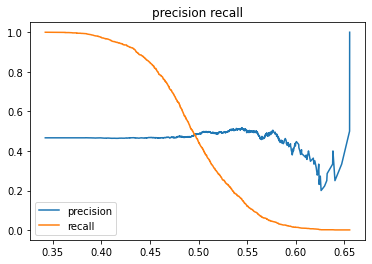

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in long_scalars


acc_pr_bythr : [5.494471e-07, 6.2675804e-07, 5.3022603e-07, 5.087027e-07, 5.5136536e-07, 6.1080453e-07, 6.0326585e-07, 5.748121e-07, 5.2369586e-07, 5.3307804e-07, 5.5210495e-07, 7.057741e-07, 6.58974e-07, 5.591803e-07, 5.655055e-07, 5.758316e-07, 6.894202e-07, 7.1397136e-07, 7.2007475e-07, 7.2624823e-07, 6.1707476e-07, 4.9643603e-07, 4.918439e-07, 4.761019e-07, 4.5023123e-07, 4.5974872e-07, 4.275601e-07, 4.3384935e-07, 4.395941e-07, 5.192968e-07, 5.2616923e-07, 5.2425094e-07, 5.433751e-07, 6.097388e-07, 6.0564554e-07, 5.7286667e-07, 5.883999e-07, 5.5435197e-07, 6.31398e-07, 6.259501e-07, 6.021334e-07, 6.094038e-07, 6.3772774e-07, 6.6291557e-07, 6.109457e-07, 5.963153e-07, 6.3412625e-07, 6.2163843e-07, 6.5233064e-07, 6.125857e-07, 6.296144e-07, 6.188554e-07, 6.711936e-07, 7.4862584e-07, 6.8056147e-07, 6.856233e-07, 7.3314754e-07, 6.942488e-07, 7.04913e-07, 6.876548e-07, 6.783237e-07, 6.871693e-07, 6.425794e-07, 6.51873e-07, 6.833177e-07, 6.9777275e-07, 6.635362e-07, 6.901573e-07, 6.7467

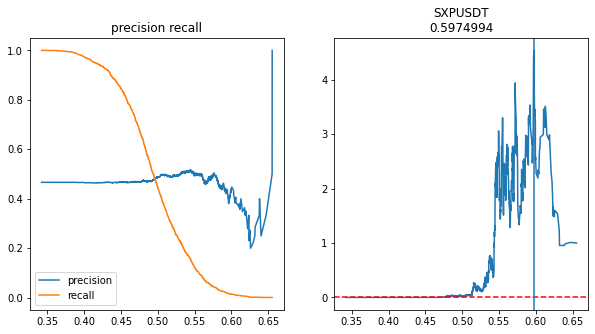

In [8]:
total_result = np.array(total_result).reshape(-1, 2)
# y_score = total_result[:, [0]]
y_score = total_result[:, [1]]
print('y_test[:5] :', y_test.reshape(-1,)[:5])
# print('np.unique(y_test) :', np.unique(y_test, return_counts=True))
print('y_score[:5] :', y_score[:5])
# print('np.unique(y_score) :', np.unique(y_score, return_counts=True))

print('y_test.shape :', y_test.shape)
print('y_score.shape :', y_score.shape)

print('len(y_test) :', len(y_test))

#     precision recall curve   #
precision, recall, threshold = precision_recall_curve(y_test[:len(y_score)], y_score)
precision, recall = precision[:-1], recall[:-1]

plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.legend()
plt.title('precision recall')
plt.show()
# print(y_pred)


# threshold = [0.591]
# print('threshold :', threshold)
# break

acc_pr_bythr = []
new_thresh = []

for thresh in threshold:
  
  # if thresh < 0.5:
  #     continue

  y_pred = np.where(y_score[:, -1] > thresh, 1, 0)
  # print('y_pred.shape :', y_pred.shape)
  # print('y_pred :', y_pred)

  #     compare precision     #

  # print('precision :', precision_score(y_test, y_pred))
  # print('recall :', recall_score(y_test, y_pred))
  # print()

  # print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
  # print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

  # # plot_confusion_matrix(best_model, x_test, y_test, normalize=None)
  # # plt.show()  
  # print()

  #     check win-ratio improvement     #
  cmat = confusion_matrix(y_test[:len(y_score)], y_pred)
  # print(cmat)
  # print(np.sum(cmat, axis=1))

  test_size = len(y_test[:len(y_score)])
  test_pr_list = pr_test[:len(y_score)]

  # short_pr_list = np.where(test_pr_list != 1, ((1 / ((test_pr_list - 1) / lvrg + 1 + fee)) - 1 - fee) * lvrg + 1, test_pr_list)
  # test_pr_list = short_pr_list
  # print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

  org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
  ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
  # print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

  # print('pr_test.shape :', pr_test.shape)

  # print(y_pred)
  # print(test_pr_list)
  pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1.0)
  pred_pr_list = np.where(np.isnan(pred_pr_list), 1.0, pred_pr_list)
  pred_pr_list = np.where(pred_pr_list == 0.0, 1.0, pred_pr_list)
  # print('pred_pr_list.shape :', pred_pr_list.shape)

  # if np.cumprod(test_pr_list)[-1] < np.cumprod(pred_pr_list)[-1]:
  #   print('accum_pr increased ! : %.3f --> %.3f' % (np.cumprod(test_pr_list)[-1], np.cumprod(pred_pr_list)[-1]))
  #   print('thresh :', thresh)
    
  if len(threshold) == 1:
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(np.cumprod(test_pr_list))
    plt.title('%.3f' % (np.cumprod(test_pr_list)[-1]))
  # plt.show()

    plt.subplot(122)
    plt.plot(np.cumprod(pred_pr_list))
    plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
    # plt.axvline(len(org_pr_test), linestyle='--', color='r')
    plt.show()


  acc_pr_bythr.append(np.cumprod(pred_pr_list)[-1])
  new_thresh.append(thresh)


print('acc_pr_bythr :', acc_pr_bythr)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.legend()
plt.title('precision recall')
# plt.show()
plt.subplot(122)
plt.plot(new_thresh, acc_pr_bythr)
plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
plt.axvline(new_thresh[np.argmax(acc_pr_bythr)])
plt.title(symbol_name + '\n' + "%s" % new_thresh[np.argmax(acc_pr_bythr)])
plt.show()

### realtime threshold

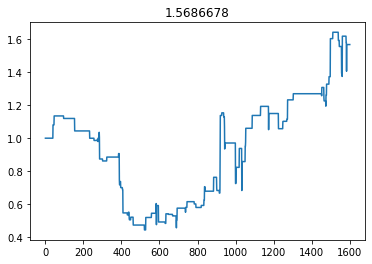

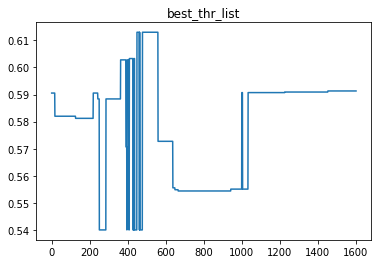

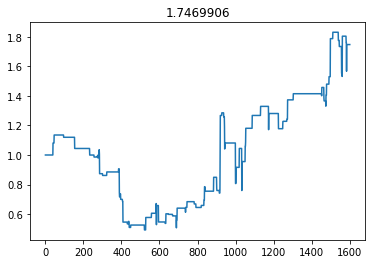

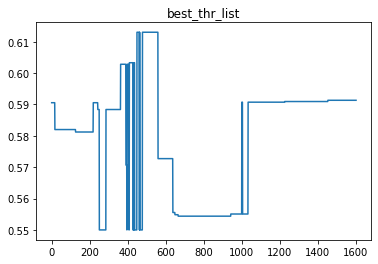

KeyboardInterrupt: ignored

In [ ]:
#   lookback n - period, find and use the best thresh for the next infer    #
lb_period = 1000

total_result = np.array(total_result).reshape(-1, 2)
y_score = total_result[:, [1]]

# def find_best_thr():
# min_thr_list = np.arange(0.60, 0.62, 0.01)
min_thr_list = np.arange(0.54, 0.56, 0.01)
# min_thr_list = [0.591]

for thr_i in tqdm(range(len(min_thr_list))):

  min_thr = min_thr_list[thr_i]

  best_thr_list = []
  new_pr_list = []
  for i in tqdm(range(lb_period, len(total_result))):

    precision, recall, threshold = precision_recall_curve(y_test[:len(y_score)][i - lb_period:i], y_score[i - lb_period:i])
    precision, recall = precision[:-1], recall[:-1]

    acc_pr_bythr = []
    new_thresh = []
    for thresh in threshold:

      if thresh < 0.5:
          continue

      #   lookback previous range   #
      y_pred = np.where(y_score[i - lb_period:i, -1] > thresh, 1, 0)

      test_size = len(y_test[:len(y_score)][i - lb_period:i])
      test_pr_list = pr_test[:len(y_score)][i - lb_period:i]

      pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1.0)
      pred_pr_list = np.where(np.isnan(pred_pr_list), 1.0, pred_pr_list)
      pred_pr_list = np.where(pred_pr_list == 0.0, 1.0, pred_pr_list)

      acc_pr_bythr.append(np.cumprod(pred_pr_list)[-1])
      new_thresh.append(thresh)
    

    #       replace best_thr only max_pr > 1      #
    # if np.max(acc_pr_bythr) > 1.10:
    best_thr = new_thresh[np.argmax(acc_pr_bythr)]

    if best_thr < min_thr:
      best_thr = min_thr

      # if best_thr < 0.52:
      #   plt.subplot(121)
      #   plt.plot(threshold, precision, label='precision')
      #   plt.plot(threshold, recall, label='recall')
      #   plt.legend()
      #   plt.title('precision recall')
      #   # plt.show()
      #   plt.subplot(122)
      #   plt.plot(new_thresh, acc_pr_bythr)
      #   plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
      #   plt.axvline(new_thresh[np.argmax(acc_pr_bythr)])
      #   plt.title(symbol_name + '\n' + "%s" % new_thresh[np.argmax(acc_pr_bythr)])
      #   plt.show()


    best_thr_list.append(best_thr)

    #   use it   #
    # print("i :", i)
    if i >= len(y_score):
      break
    new_pr = np.where(y_score[i, -1] > best_thr, pr_test[:len(y_score)][i], 1)

    if new_pr == 0:
      continue

    #   use moving average  #
    # ma_period = 5
    # if len(best_thr_list) > ma_period:
    #   new_pr = np.where(y_score[i, -1] > np.mean(best_thr_list[-ma_period:]), pr_test[:len(y_score)][i], 1)

    new_pr_list.append(new_pr)

  plt.plot(np.cumprod(new_pr_list))
  plt.title(np.cumprod(new_pr_list)[-1])
  plt.show()

  plt.plot(best_thr_list)
  plt.title("best_thr_list")
  plt.show()




### short ver.

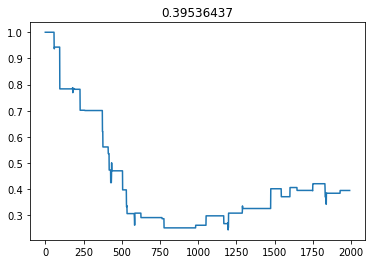

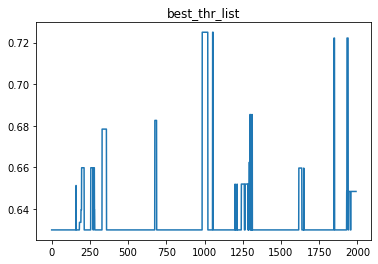

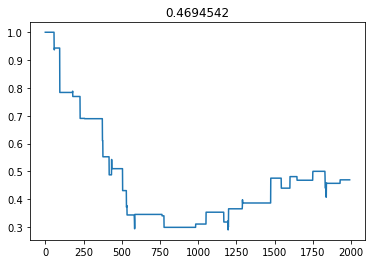

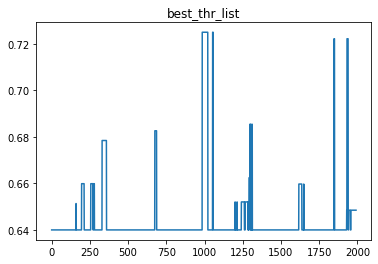

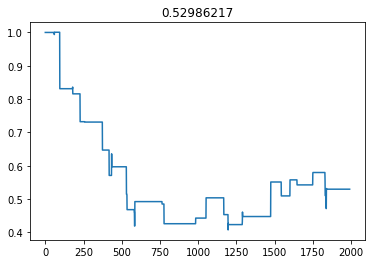

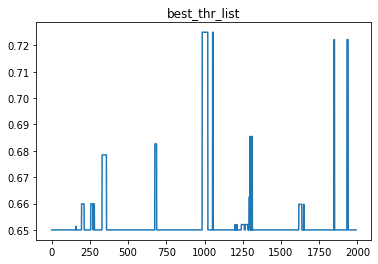

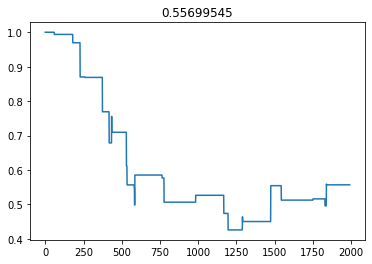

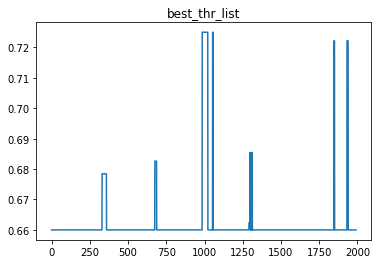

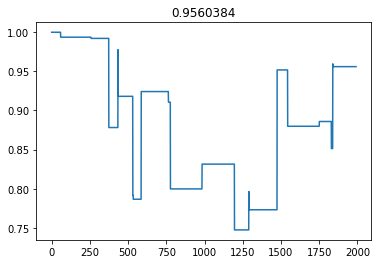

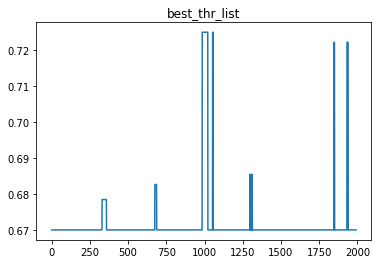

In [ ]:
#   lookback n - period, find and use the best thresh for the next infer    #
lb_period = 100
lvrg = 5
fee = 0.0006

total_result = np.array(total_result).reshape(-1, 2)
y_score = total_result[:, [0]]

# def find_best_thr():
min_thr_list = np.arange(0.63, 0.67, 0.01)

for thr_i in tqdm(range(len(min_thr_list))):

  min_thr = min_thr_list[thr_i]

  best_thr_list = []
  new_pr_list = []
  for i in tqdm(range(lb_period, len(total_result))):

    precision, recall, threshold = precision_recall_curve(y_test[:len(y_score)][i - lb_period:i], y_score[i - lb_period:i])
    precision, recall = precision[:-1], recall[:-1]

    acc_pr_bythr = []
    new_thresh = []
    for thresh in threshold:

      if thresh < 0.5:
          continue

      #   lookback previous range   #
      y_pred = np.where(y_score[i - lb_period:i, -1] > thresh, 1, 0)

      test_size = len(y_test[:len(y_score)][i - lb_period:i])
      test_pr_list = pr_test[:len(y_score)][i - lb_period:i]

      short_pr_list = np.where(test_pr_list != 1, ((1 / ((test_pr_list - 1) / lvrg + 1 + fee)) - 1 - fee) * lvrg + 1, test_pr_list)
      test_pr_list = short_pr_list

      pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1.0)
      pred_pr_list = np.where(np.isnan(pred_pr_list), 1.0, pred_pr_list)
      pred_pr_list = np.where(pred_pr_list == 0.0, 1.0, pred_pr_list)

      acc_pr_bythr.append(np.cumprod(pred_pr_list)[-1])
      new_thresh.append(thresh)
    

    #       replace best_thr only max_pr > 1      #
    # if np.max(acc_pr_bythr) > 1.10:
    best_thr = new_thresh[np.argmax(acc_pr_bythr)]

    if best_thr < min_thr:
      best_thr = min_thr

      # if best_thr < 0.52:
      #   plt.subplot(121)
      #   plt.plot(threshold, precision, label='precision')
      #   plt.plot(threshold, recall, label='recall')
      #   plt.legend()
      #   plt.title('precision recall')
      #   # plt.show()
      #   plt.subplot(122)
      #   plt.plot(new_thresh, acc_pr_bythr)
      #   plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
      #   plt.axvline(new_thresh[np.argmax(acc_pr_bythr)])
      #   plt.title(symbol_name + '\n' + "%s" % new_thresh[np.argmax(acc_pr_bythr)])
      #   plt.show()


    best_thr_list.append(best_thr)

    #   use it   #
    new_pr = np.where(y_score[i, -1] > best_thr, pr_test[:len(y_score)][i], 1)

    #   use moving average  #
    # ma_period = 5
    # if len(best_thr_list) > ma_period:
    #   new_pr = np.where(y_score[i, -1] > np.mean(best_thr_list[-ma_period:]), pr_test[:len(y_score)][i], 1)

    new_pr_list.append(new_pr)

  plt.plot(np.cumprod(new_pr_list))
  plt.title(np.cumprod(new_pr_list)[-1])
  plt.show()

  plt.plot(best_thr_list)
  plt.title("best_thr_list")
  plt.show()




In [ ]:
# model = FER_Model(input_shape=(45, 1))

period = 45
symbol_name = 'SXPUSDT'

ckpt_path = current_path + 'ckpt/'
board_path = current_path + 'graph/'
model_name = 'classifier_%s_lstm_close_updown_pr_robust_trial_re_%s_timesplit.h5' % (period, symbol_name)

# model_name = 'classifier_%s_close_updown_pr_theta_shuffle_without_back_03.h5' % period

model = keras.models.load_model(ckpt_path + model_name)


In [ ]:
for l_i, layer in enumerate(model.layers):

  if l_i != len(model.layers) - 1:
    layer.trainable = False

  print(layer, layer.trainable)


In [ ]:
min_max = MinMaxScaler()
cbo1 = min_max.fit_transform(cbo.values.reshape(-1, 1))
bbw1 = min_max.fit_transform(bbw.values.reshape(-1, 1))

min_max = MinMaxScaler()
bbw2 = min_max.fit_transform(bbw.values.reshape(-1, 1))

print(bbw1[-10:])
print(bbw2[-10:])
plt.plot(bbw1)
plt.plot(bbw2)

plt.show()

print(len(bbw1))

### Check shuffled index

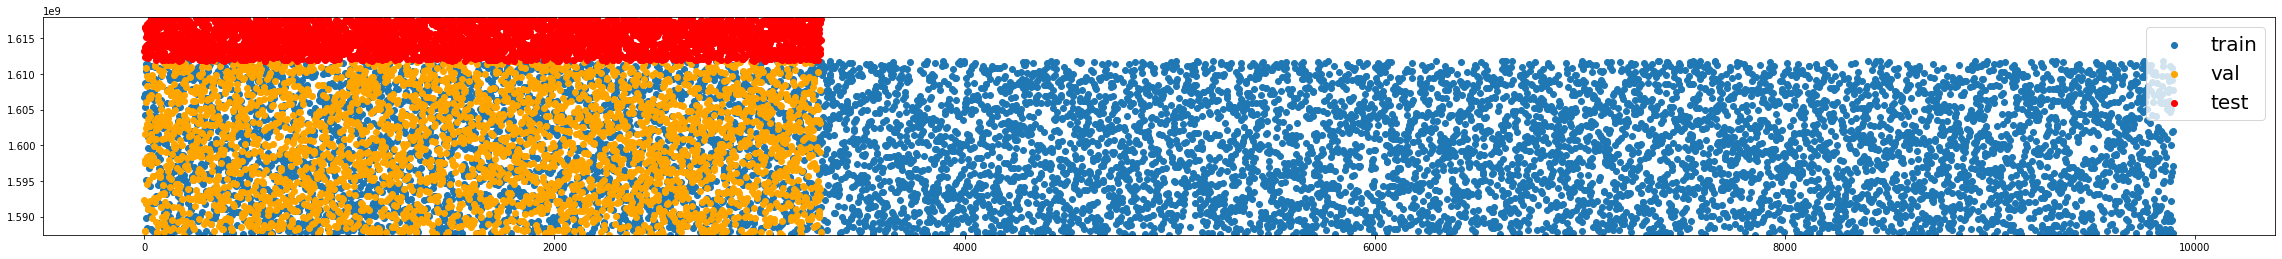

In [ ]:
# print(index_val)
from datetime import datetime

# print(index_test)
# print(index_train)
# print(index_val)
total_stamp = list(map(lambda x: datetime.timestamp(x[0]), input_index)) 
timestamp_train = list(map(lambda x: datetime.timestamp(x[0]), index_train)) 
timestamp_val = list(map(lambda x: datetime.timestamp(x[0]), index_val)) 
timestamp_test = list(map(lambda x: datetime.timestamp(x[0]), index_test)) 
# print(total_stamp)
# print(timestamp_train)
plt.figure(figsize=(40, 4))
plt.scatter(range(len(timestamp_train)), timestamp_train, label='train')
plt.scatter(range(len(timestamp_val)), timestamp_val, color='orange', label='val')
plt.scatter(range(len(timestamp_test)), timestamp_test, color='red', label='test')
plt.ylim(min(total_stamp), max(total_stamp))
plt.legend(fontsize=20)

# print(new_input_index)

### Load Data

In [ ]:
period = 45

x_save_path = current_path + 'npy/' + '%s_rnn_close_updown_x_train_neo_timesplit.npy' % period
x_train = np.load(x_save_path)
x_val = np.load(x_save_path.replace('x_train', 'x_val'))
x_test = np.load(x_save_path.replace('x_train', 'x_test'))
print('x series loaded !')

pr_save_path = current_path + 'npy/' + '%s_rnn_close_updown_pr_train_neo_timesplit.npy' % period
pr_train = np.load(pr_save_path)
pr_val = np.load(pr_save_path.replace('pr_train', 'pr_val'))
pr_test = np.load(pr_save_path.replace('pr_train', 'pr_test'))
print('y series loaded !')

_, row, col = x_train.shape



x series loaded !
y series loaded !


In [ ]:
print(keras.__version__)
print(tf.__version__)

2.3.1
1.15.2


### **Data Split**

### **Training**

In [ ]:
org_x_test = x_test
org_y_test = y_test
org_pr_test = pr_test

In [ ]:
x_test = org_x_test
y_test = org_y_test
pr_test = org_pr_test

In [ ]:
concat_x = np.vstack((org_x_test, new_input_x))
concat_y = np.vstack((org_y_test, np.where(new_input_pr > 1, 1, 0)))
concat_pr = np.vstack((org_pr_test, new_input_pr))

In [ ]:
x_test = new_input_x
y_test = np.where(new_input_pr > 1, 1, 0)
pr_test = new_input_pr

In [ ]:
# print(pred_pr_list)
for pr in pred_pr_list:
  if pr != 1:
    print(pr)

In [ ]:
plt.figure(figsize=(50, 5))
plt.plot(np.cumprod(pred_pr_list)[len(org_pr_test):len(org_pr_test) + 10])
# plt.plot(np.cumprod(pred_pr_list)[len(org_pr_test) - 10:len(org_pr_test) + 10])
plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
# plt.axvline(len(org_pr_test), linestyle='--', color='r')
plt.show()

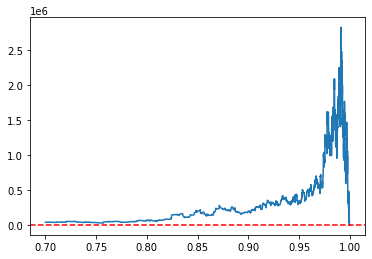

In [ ]:
# plt.show()
# plt.subplot(122)
plt.plot(new_thresh, acc_pr_bythr)
plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
plt.show()

#### **clustering output**

In [ ]:
# x_train_for_k = test_result.flatten().reshape(-1, 1)
x_train_for_k = test_result
print(x_train_for_k[:10])
# x_train_for_k = test_result[:, [1]]
pr_train = pr_test

print('x_train_for_k.shape :', x_train_for_k.shape)
print('pr_train.shape :', pr_train.shape)

K = range(2, 10)
s_dist = []
sil = []
for k in K:
  # if cen_data.shape[0] < k:
  #   break

  km = KMeans(n_clusters=k)
  km = km.fit(x_train_for_k)

  labels = km.labels_
  # print('len(labels) :', len(labels))
  # print('labels[:10] :', labels[:10])
  sil.append(silhouette_score(x_train_for_k, labels, metric='euclidean'))

  # inertia = km.inertia_
  # s_dist.append(inertia)

best_k = K[np.argmax(np.array(sil))]

plt.figure(figsize=(10, 5))
plt.plot(K, sil)
plt.axvline(best_k, linestyle='--')
# plt.plot(K, s_dist)
plt.show()





#   with best_k, label 별 pr_list 확인
km = KMeans(n_clusters=best_k)
km = km.fit(x_train_for_k)

labels = km.labels_

print(km.score(x_train_for_k))
print(len(labels), len(pr_train))





#   label 별로 profit 을 저장, 승률을 확인한다
label_types = np.unique(labels, return_counts=False)

label_pr_dict = {}
#   init dict   #
for label in label_types:
  label_pr_dict[label] = []
print(label_pr_dict)
# break

for i, (label, pr) in enumerate(zip(labels, pr_train)):
  label_pr_dict[label].append(pr[0])

  
# for label in label_types:
print(label_pr_dict)





def win_ratio(list_x):

  win_cnt = np.sum(np.array(list_x) > 1)
  return win_cnt / len(list_x)


def acc_pr(list_x):

  return np.cumprod(np.array(list_x))[-1]


for key in label_pr_dict:
  
  print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))





#     predict test && test 의 라벨에 따른 win_ratio 확인
# test_labels = km.predict(x_test)
# # print(test_labels)

# label_pr_dict = {}
# #   init dict   #
# for label in label_types:
#   label_pr_dict[label] = []
# print(label_pr_dict)
# # break

# for i, (label, pr) in enumerate(zip(test_labels, pr_test)):
#   label_pr_dict[label].append(pr[0])

# for key in label_pr_dict:

#   print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))

